# Predicting Stock Prices using a Recurrent Neural Network

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import numpy as np
import matplotlib.pyplot as plt


## Data Preprocessing

In [ ]:
# Load the dataset
df = pd.read_csv("https://raw.githubusercontent.com/sumeir/data-mining-project/main/DowJones.csv")

values = df["Value"].values.reshape(-1, 1)

# Normalize the values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

In [ ]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : (i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

sequence_length = 4
X, y = create_sequences(scaled_values, sequence_length)

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshaping for the LSTM layer
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Training the Model

In [ ]:
# Building the RNN model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # 20% dropout
model.add(LSTM(units=50))
model.add(Dropout(0.2))  # 20% dropout
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=100, batch_size=32)


Epoch 1/100
52/52 [==============================] - 4s 6ms/step - loss: 0.0146
Epoch 2/100
52/52 [==============================] - 0s 10ms/step - loss: 0.0011
Epoch 3/100
52/52 [==============================] - 0s 9ms/step - loss: 9.4609e-04
Epoch 4/100
52/52 [==============================] - 0s 9ms/step - loss: 8.8715e-04
Epoch 5/100
52/52 [==============================] - 1s 10ms/step - loss: 7.3979e-04
Epoch 6/100
52/52 [==============================] - 0s 9ms/step - loss: 7.0133e-04
Epoch 7/100
52/52 [==============================] - 0s 6ms/step - loss: 7.3369e-04
Epoch 8/100
52/52 [==============================] - 0s 6ms/step - loss: 7.1390e-04
Epoch 9/100
52/52 [==============================] - 0s 6ms/step - loss: 7.5531e-04
Epoch 10/100
52/52 [==============================] - 0s 6ms/step - loss: 7.2288e-04
Epoch 11/100
52/52 [==============================] - 0s 6ms/step - loss: 6.4703e-04
Epoch 12/100
52/52 [==============================] - 0s 6ms/step - loss: 5.9862

In [ ]:
# Making predictions
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(
    predicted_stock_price
)  # Invert scaling

y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # Invert scaling
y_sub = y_test.reshape(-1, 1)

13/13 [==============================] - 1s 3ms/step


## Evaluation

0.026957970458826735
213
Mean Absolute Error for Deltas: 217.5675821724398


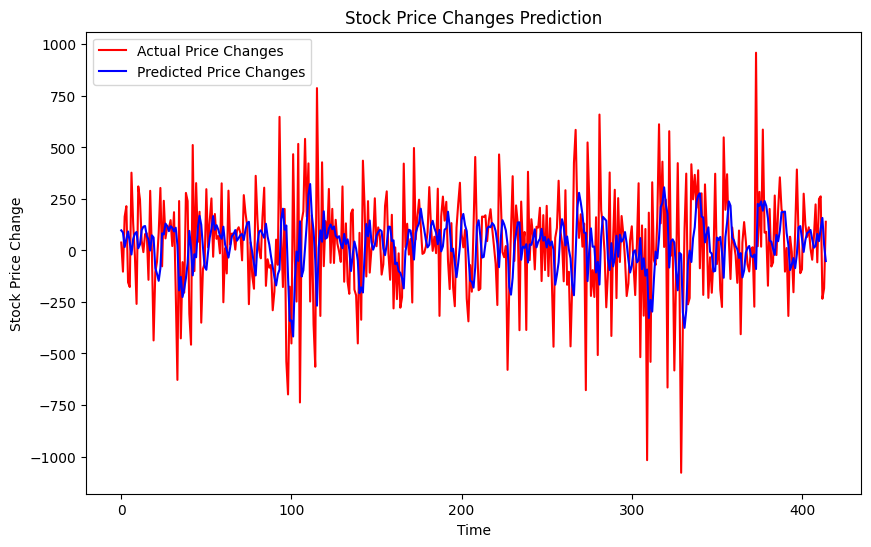

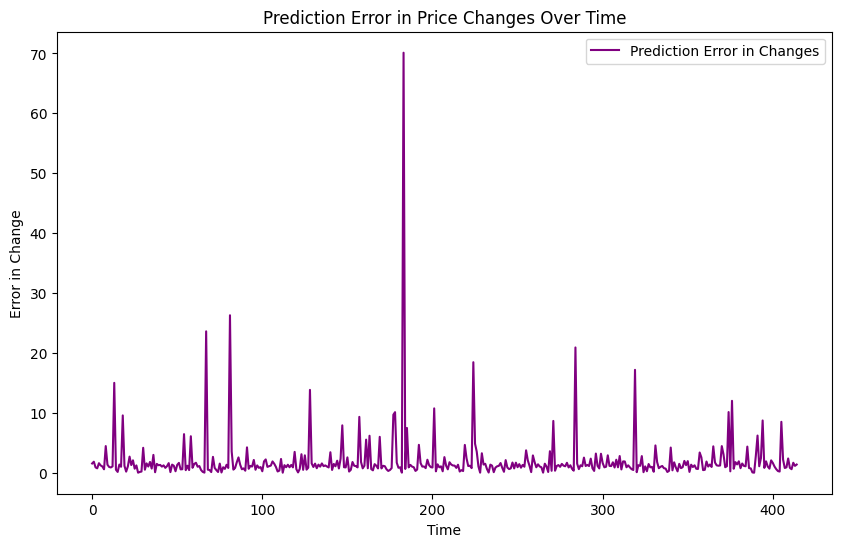

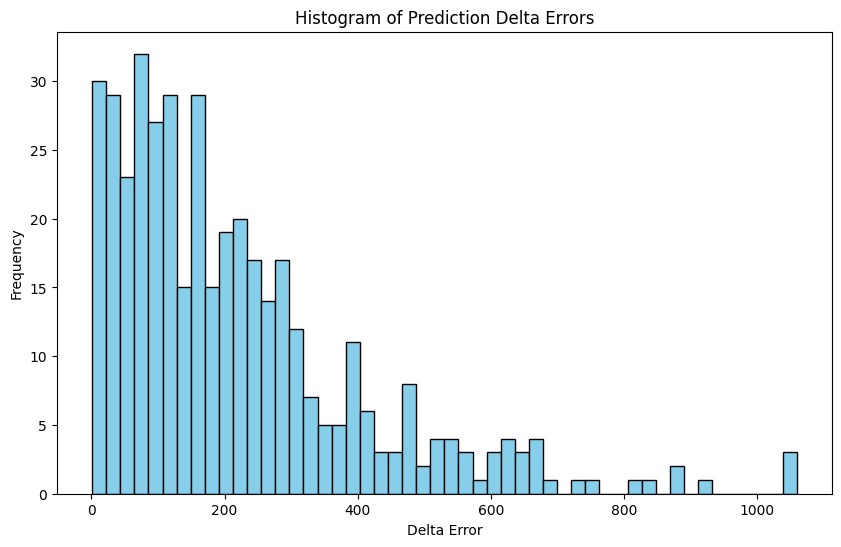

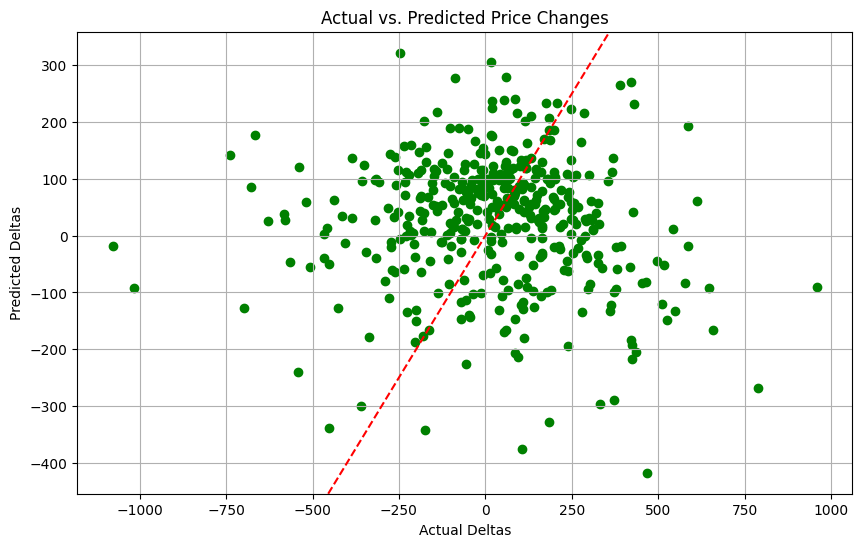

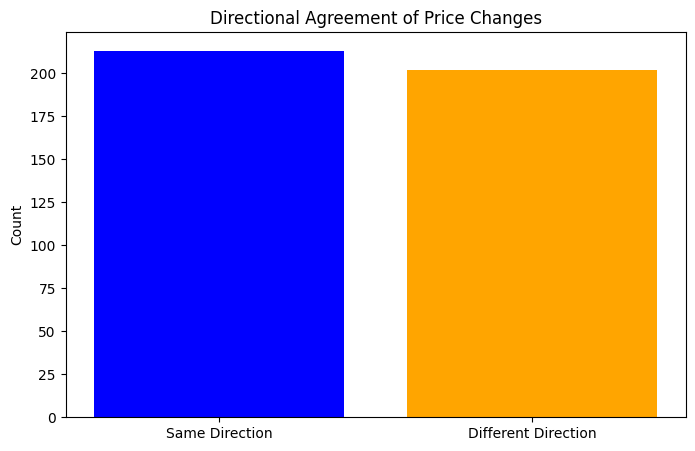

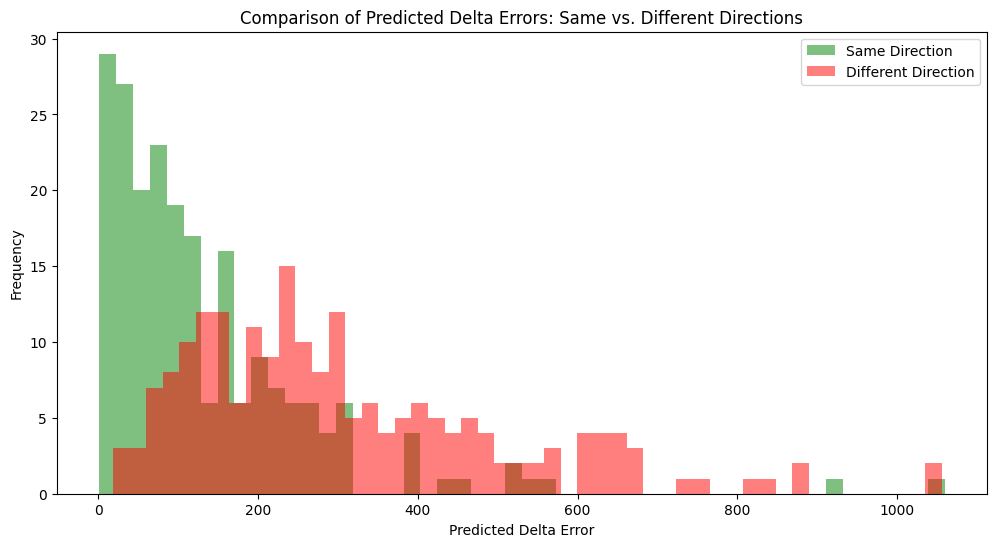

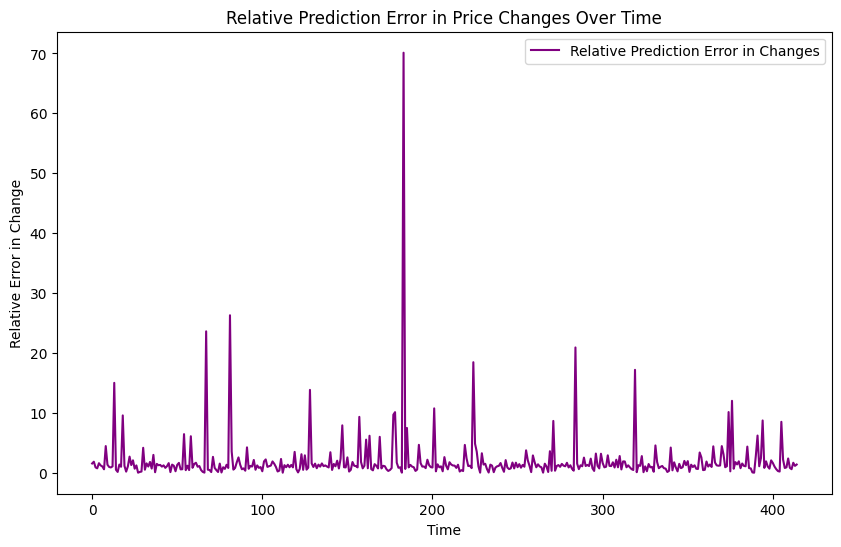

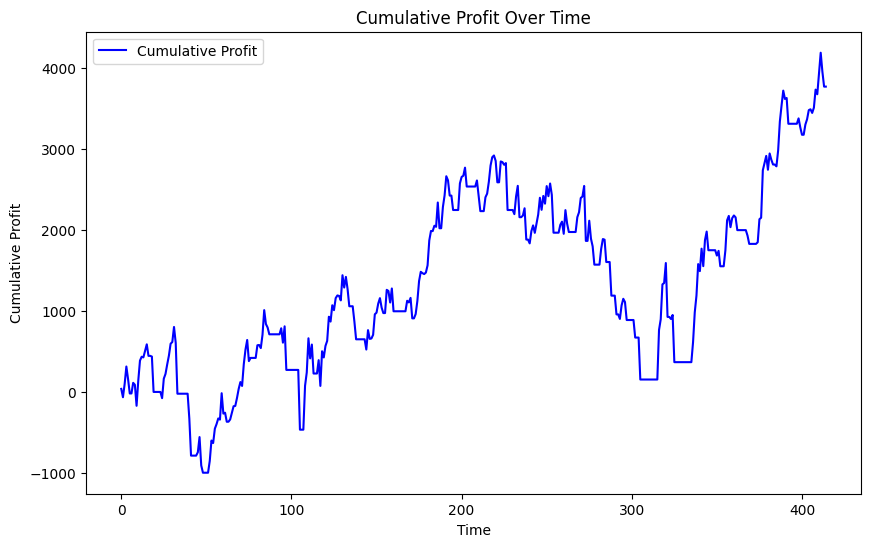

Final Cumulative Profit: 3768.9099999999944


In [ ]:
print(np.mean(np.abs((y_test - predicted_stock_price) / y_test)))

# Calculate deltas for actual and predicted prices
actual_deltas = np.diff(y_test.reshape(-1, 1), axis=0)
predicted_deltas = np.diff(predicted_stock_price, axis=0)

# Determine the sign (positive or negative) of each delta
actual_signs = actual_deltas > 0
predicted_signs = predicted_deltas > 0

# Count the number of times the deltas have the same sign
# Both positive or both negative
same_direction_count = np.sum((actual_signs == predicted_signs).astype(int))
print(same_direction_count)


# Calculate errors between predicted and actual deltas
delta_errors = np.abs(predicted_deltas - actual_deltas)
print("Mean Absolute Error for Deltas:", np.mean(delta_errors))

# Plotting actual vs predicted deltas
plt.figure(figsize=(10, 6))
plt.plot(actual_deltas, color='red', label='Actual Price Changes')
plt.plot(predicted_deltas, color='blue', label='Predicted Price Changes')
plt.title('Stock Price Changes Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price Change')
plt.legend()
plt.show()

# Optionally, plot the error in deltas over time
plt.figure(figsize=(10, 6))
plt.plot(abs(delta_errors/actual_deltas), color='purple', label='Prediction Error in Changes')
plt.title('Prediction Error in Price Changes Over Time')
plt.xlabel('Time')
plt.ylabel('Error in Change')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.hist(delta_errors, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Prediction Delta Errors')
plt.xlabel('Delta Error')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(actual_deltas, predicted_deltas, color='green')
plt.title('Actual vs. Predicted Price Changes')
plt.xlabel('Actual Deltas')
plt.ylabel('Predicted Deltas')
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Adds a reference line for perfect predictions
plt.grid(True)
plt.show()

directional_agreement = [same_direction_count, len(actual_deltas) - same_direction_count]

plt.figure(figsize=(8, 5))
bar_labels = ['Same Direction', 'Different Direction']
plt.bar(bar_labels, directional_agreement, color=['blue', 'orange'])
plt.title('Directional Agreement of Price Changes')
plt.ylabel('Count')
plt.show()

# Identifying indices where directions are the same and where they are different
same_direction_indices = np.where(actual_signs == predicted_signs)[0]
different_direction_indices = np.where(actual_signs != predicted_signs)[0]

# Separating delta errors based on the direction agreement
errors_same_direction = delta_errors[same_direction_indices]
errors_different_direction = delta_errors[different_direction_indices]

# Plotting histograms
plt.figure(figsize=(12, 6))
plt.hist(errors_same_direction, bins=50, alpha=0.5, label='Same Direction', color='green')
plt.hist(errors_different_direction, bins=50, alpha=0.5, label='Different Direction', color='red')
plt.title('Comparison of Predicted Delta Errors: Same vs. Different Directions')
plt.xlabel('Predicted Delta Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


relative_errors = np.where(actual_deltas != 0, delta_errors / np.abs(actual_deltas), 0)

plt.figure(figsize=(10, 6))
plt.plot(relative_errors, color='purple', label='Relative Prediction Error in Changes')
plt.title('Relative Prediction Error in Price Changes Over Time')
plt.xlabel('Time')
plt.ylabel('Relative Error in Change')
plt.legend()
plt.show()


# Initialize profit and cumulative profit lists
profit = []
cumulative_profit = []

# Simulate trading strategy
for i in range(len(predicted_deltas)):
    # Assuming we 'buy' if the prediction is for the price to go up, and 'sell' otherwise
    # Profit is calculated as the actual change in price
    profit.append(actual_deltas[i] * (predicted_deltas[i] > 0))
    cumulative_profit.append(np.sum(profit))

# Convert lists to numpy arrays for easier manipulation
profit = np.array(profit)
cumulative_profit = np.array(cumulative_profit)

# Plotting cumulative profit over time
plt.figure(figsize=(10, 6))
plt.plot(cumulative_profit, color='blue', label='Cumulative Profit')
plt.title('Cumulative Profit Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Profit')
plt.legend()
plt.show()

# Printing the final cumulative profit
print(f"Final Cumulative Profit: {cumulative_profit[-1]}")

1/1 [==============================] - 1s 769ms/step


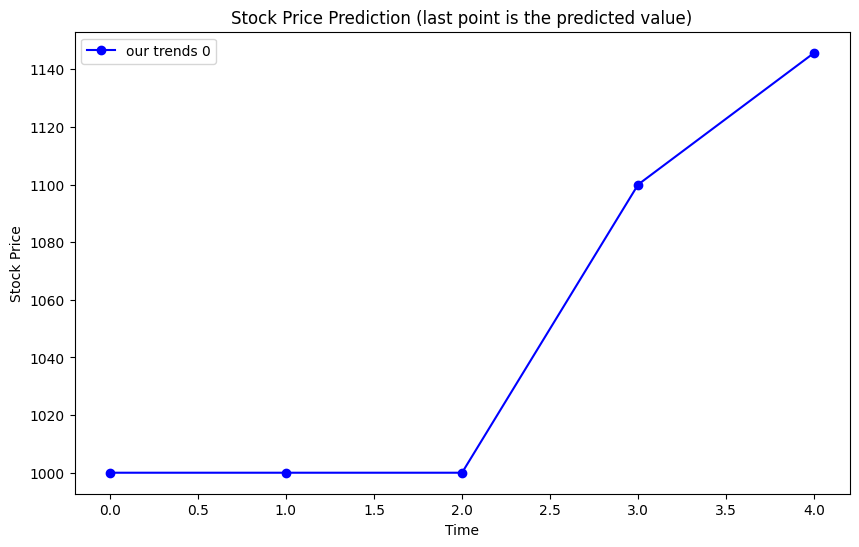

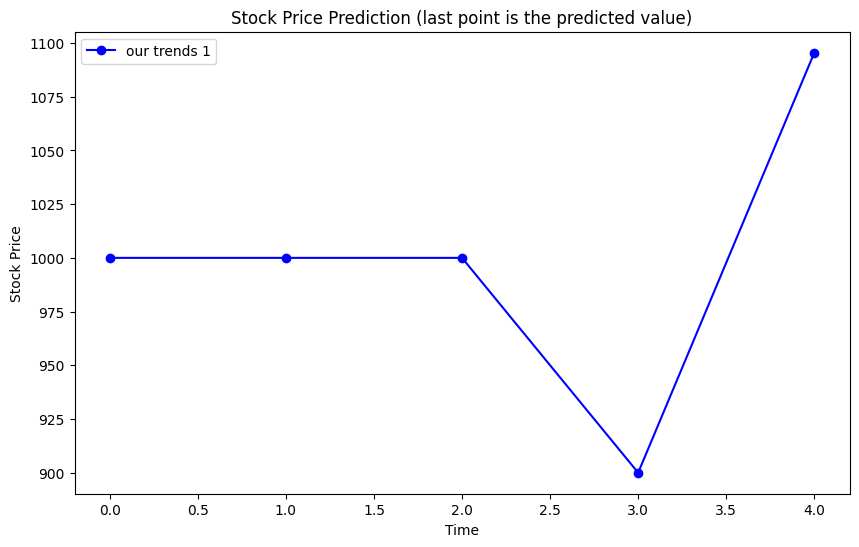

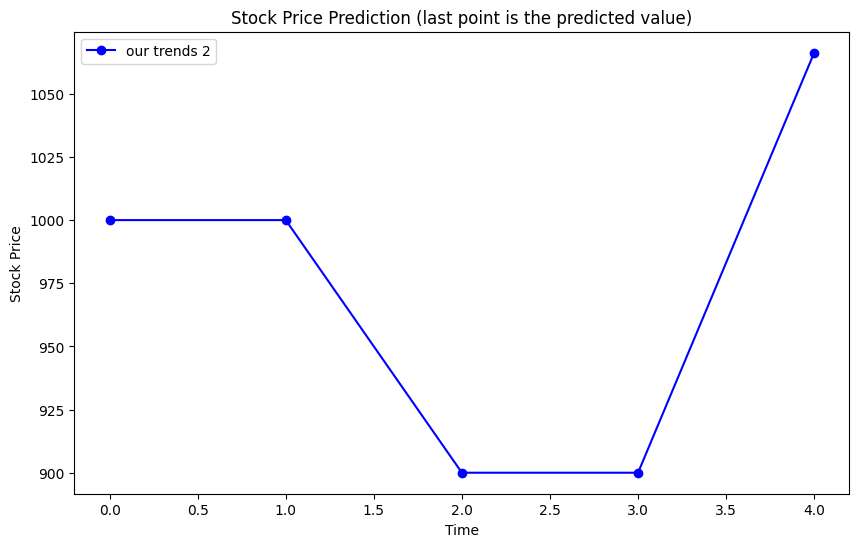

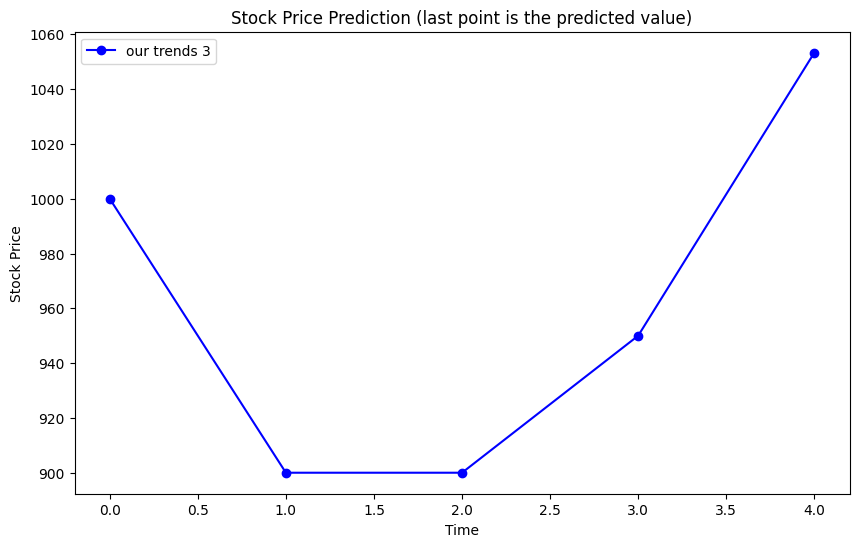

In [ ]:
# Define your data
data = [
    [[1000], [1000], [1000], [1100]],
    [[1000], [1000], [1000], [900]],
    [[1000], [1000], [900], [900]],
    [[1000], [900], [900], [950]],
]

# Convert list to numpy array
np_array = np.array(data)
np_array_reshaped = np_array.reshape(-1, 1)
np_array_scaled = scaler.transform(np_array_reshaped)
np_array_scaled = np_array_scaled.reshape(np_array.shape)


predicted_stock_price = model.predict(np_array_scaled)

np_array_scaled_reshaped = np_array_scaled.reshape(-1, 1)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

ourTrends = data
for i in range(len(predicted_stock_price)):
    ourTrends[i].append([predicted_stock_price[i][0]])

# Plotting the data and predictions
plt.figure(figsize=(10, 6))
plt.plot(ourTrends[0], color="blue", label="our trends 0", marker="o")
plt.title("Stock Price Prediction (last point is the predicted value)")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(ourTrends[1], color="blue", label="our trends 1", marker="o")
plt.title("Stock Price Prediction (last point is the predicted value)")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(ourTrends[2], color="blue", label="our trends 2", marker="o")
plt.title("Stock Price Prediction (last point is the predicted value)")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(ourTrends[3], color="blue", label="our trends 3", marker="o")
plt.title("Stock Price Prediction (last point is the predicted value)")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
